In [1]:
from sklearn.model_selection import KFold
import pickle
import pandas as pd
response = pd.read_csv("1127_final_data/response.csv", header=None) #input X
spectra = pd.read_csv("1127_final_data/spectra.csv", header=None) #ground truth label Y
import os.path
file_name = 'resampled_2x5_cross_validation'
if os.path.isfile(file_name+'.pickle'): 
    with open(file_name+'.pickle', 'rb') as handle:
        train_indices,test_indices = pickle.load(handle)  
else:
    # 2x5 resampling
    train_indices = []
    test_indices = []
    number_resamples = 2
    n_splits =5
    for i in range(number_resamples):
        kf = KFold(n_splits=n_splits, random_state=i, shuffle=True)
        for i, (train_index, test_index) in enumerate(kf.split(range(len(response)))):
            train_indices.append(train_index)
            test_indices.append(test_index)
    with open(file_name+'.pickle', 'wb') as handle:
        pickle.dump([train_indices,test_indices], handle, protocol=pickle.HIGHEST_PROTOCOL)
                                            

In [2]:
import torch
import torch.nn as nn
class Model(torch.nn.Module):
    def __init__(self,device, input_dim=64):
        super().__init__()
        self.relu  = nn.ReLU()
        self.hidden_dim = 512
        self.linear1 = torch.nn.Linear(input_dim, self.hidden_dim)
        self.linear2= torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.linear3= torch.nn.Linear(self.hidden_dim, 251)
        self.device = device
        self.to(device)
    def forward(self, x):
        y= self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))
        y = torch.sigmoid(y)
        return y


In [3]:
from torch.utils.data import DataLoader
from torch import optim
import numpy as np
class CalculateMSE():
    def __init__(self, net,n_epochs,batch_size ):
        super().__init__()
        self.net = net
        #initialize some constants
        self.batch_size = 32
        self.learning_rate = 1e-4
        self.n_epochs = n_epochs
        self.net.apply(self.weights_init)   
    def weights_init(self,layer):
        if type(layer) == nn.Linear:
            nn.init.orthogonal_(layer.weight)
    def get_mse(self,train_data, train_label, test_data, test_label):
        train_set = torch.utils.data.TensorDataset(
            torch.Tensor(train_data), 
            torch.Tensor(train_label))
        val_set = torch.utils.data.TensorDataset(
            torch.Tensor(test_data), 
            torch.Tensor(test_label))
        loader_args = dict(batch_size=self.batch_size)
        train_loader = DataLoader(train_set, shuffle=True, drop_last=True, **loader_args)
        val_loader = DataLoader(val_set, shuffle=True, drop_last=True, **loader_args)
        tloss = []
        vloss = []
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate) # weight_decay=0
        for epoch in range(0, self.n_epochs):
            epoch_train_loss=[]
            for i, data in enumerate(train_loader, 0):
                inputs, label = data
                y_pred = self.net(inputs.to(self.net.device))
                loss = criterion(y_pred, label.to(self.net.device))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_train_loss.append(loss.item())
            tloss.append(np.mean(epoch_train_loss))
            epoch_loss=[]
            for i, data in enumerate(val_loader, 0):
                with torch.no_grad():
                    inputs1, label1 = data
                    y_pred1 = self.net(inputs1.to(self.net.device))
                    loss1 = criterion(y_pred1, label1.to(self.net.device))
                    epoch_loss.append(loss1.item())
            vloss.append(np.mean(epoch_loss))
        return np.min(vloss), self.net


In [4]:
from pathlib import Path
n_epochs=3000
batch_size=32
PATH = 'saved_model/DNN/'
Path(PATH).mkdir(parents=True, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
response = pd.read_csv("1127_final_data/response.csv", header=None).values #input X
spectra = pd.read_csv("1127_final_data/spectra.csv", header=None).values #ground truth label Y
mdl = Model(device=device, input_dim=64)
losses = []
for i,(train,test) in enumerate(zip(train_indices,test_indices)):
    train_data, train_label= response[train],spectra[train]
    test_data, test_label= response[test],spectra[test]
    mse_calculator = CalculateMSE(mdl,n_epochs,batch_size)
    loss,model = mse_calculator.get_mse(train_data, train_label, test_data, test_label)
    losses.append(loss)
    print(i,loss)
    torch.save(model.state_dict(), PATH+'model'+str(i))

0 0.008531031548045576
1 0.008500274503603578
2 0.00775504729244858
3 0.009730588062666357
4 0.0077604822969685
5 0.006919999839738011
6 0.008976209093816578
7 0.010743244551122189
8 0.00835244528328379
9 0.008204263596174618


In [5]:
print(np.mean(losses),np.std(losses))

0.008547358606786777 0.0010227060547437017


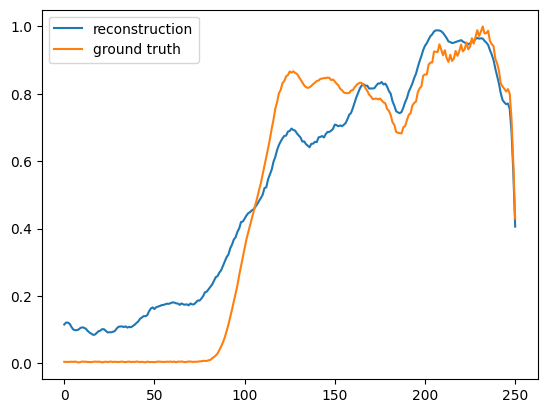

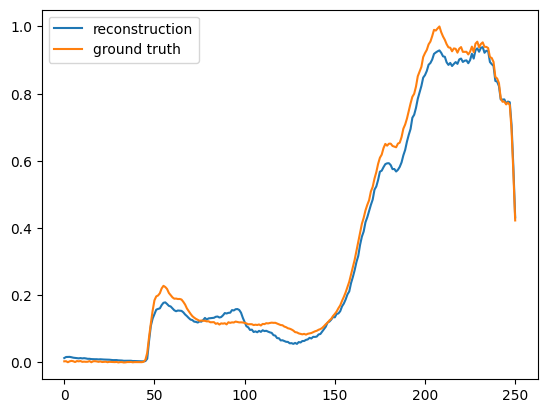

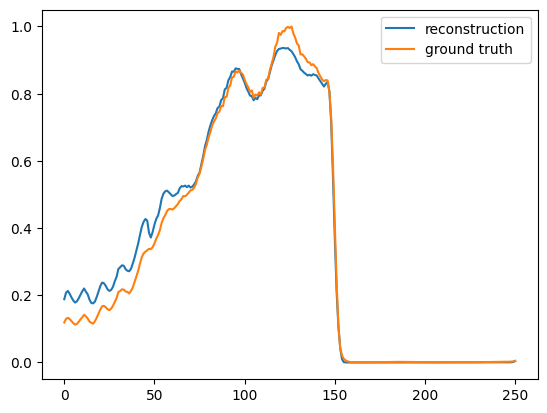

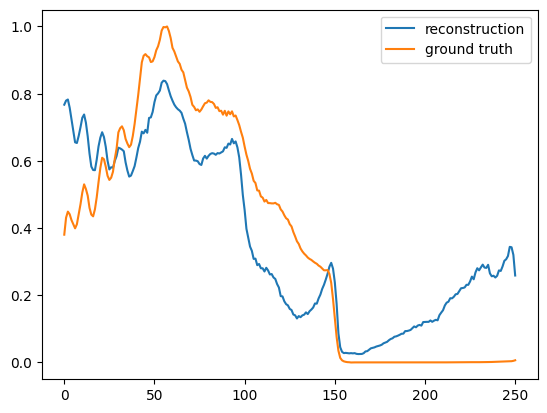

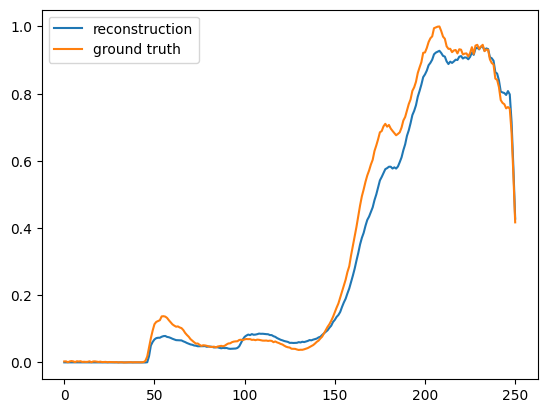

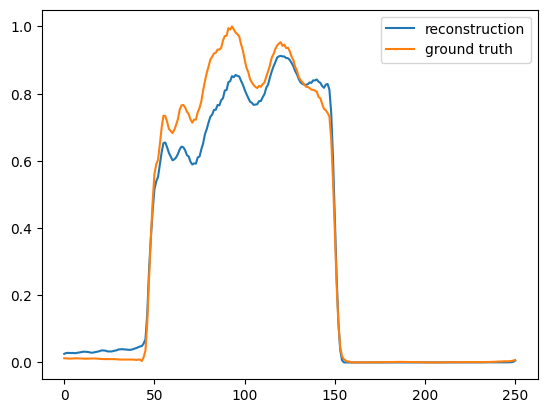

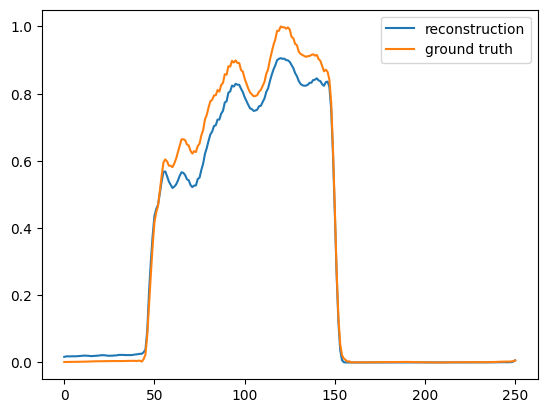

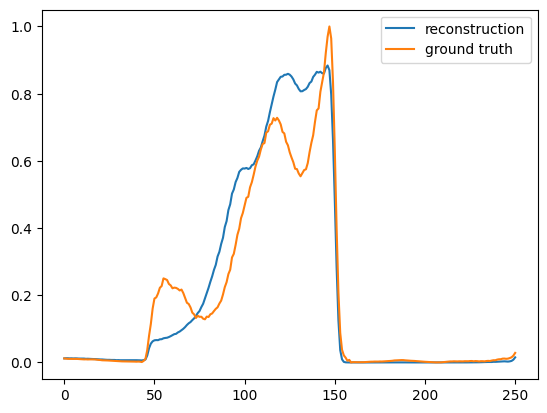

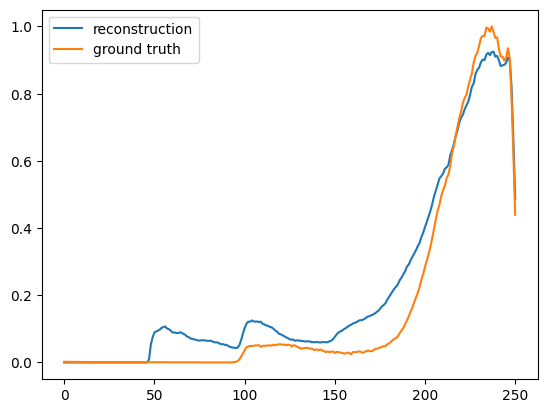

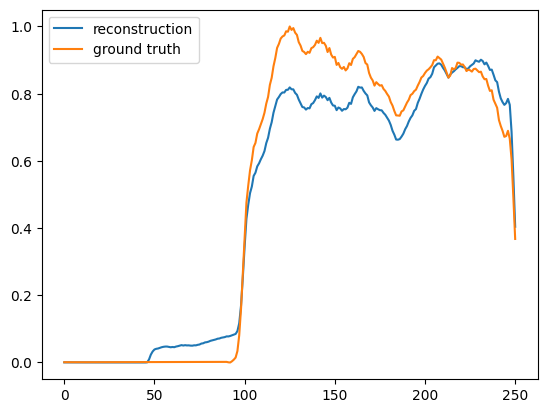

In [6]:
number_figures = 10
import matplotlib.pyplot as plt

indices = torch.randint(0,len(response),(number_figures,)).unique()
for i in indices:
    res = response[i].flatten()
    spec = spectra[i].flatten()
    plt.figure(i)

    plt.plot(model(torch.Tensor(res).to(model.device)).detach().cpu().flatten())
    plt.plot(spec)
    plt.legend(['reconstruction','ground truth'])


In [3]:
from pathlib import Path
PATH = 'saved_model/DNN/'
device = torch.device("cuda")
mdl = Model(device=device, input_dim=64)

from scipy import stats,spatial
#pip install dtw-python
from dtw import *
import torch
import numpy as np
response = pd.read_csv("1127_final_data/response.csv", header=None).values #input X
spectra = pd.read_csv("1127_final_data/spectra.csv", header=None).values #ground truth label Y
correlation_losses = []

def calculate_correlation(model, test_data, test_label):
    test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)
    construction = model(test_data_tensor).detach().cpu().numpy()
   
    # Pearson
    pearson_coefs = []
    pearson_ps = []
    
    # Kendall
    kendall_coefs = []
    kendall_ps = []
    
    # Spearman
    spearman_coefs = []
    spearman_ps = []
    
    # Distance Correlation
    distance_corr = []
    
    #DTW distance
    alignment = []
    
    #absolute_error
    abs_err = []
    
    for i in range(test_label.shape[0]):
        x1 = construction[i,:]
        x2 = test_label[i,:]
        
        res = stats.pearsonr(x1, x2)
        pearson_coefs.append(res[0])
        pearson_ps.append(res[1])
        
        res = stats.kendalltau(x1, x2)
        kendall_coefs.append(res[0])
        kendall_ps.append(res[1])
        
        res = stats.spearmanr(x1, x2)
        spearman_coefs.append(res[0])
        spearman_ps.append(res[1])
        
        distance_corr.append(1- spatial.distance.correlation(x1,x2))
        
        alignment.append(dtw(x1, x2, distance_only=True).distance)
        abs_err.append(abs(x1-x2))
        
    correlation_results = {
        'pearson': (pearson_coefs, pearson_ps),
        'kendall': (kendall_coefs, kendall_ps),
        'spearman': (spearman_coefs, spearman_ps),
        'DTW': alignment,
        'Absolute Error': abs_err,
        'Distance Correlation': distance_corr
    }

    return correlation_results

for i, (train, test) in enumerate(zip(train_indices, test_indices)):
    print(i)
    train_data, train_label = response[train], spectra[train]
    test_data, test_label = response[test], spectra[test]
    
    mdl_name = PATH + 'model' + str(i)
    mdl.load_state_dict(torch.load(mdl_name))
    mdl.eval()
    
    correlation_loss = calculate_correlation(mdl, test_data, test_label)
    correlation_losses.append(correlation_loss)
for key in correlation_losses[0].keys():
    print(key)
    if key=='Absolute Error':
        errors = []
        for d in correlation_losses:
            errors+=np.concatenate(d[key]).ravel().tolist()
        #percentile
        percentiles = [5, 50, 90, 95, 99]
        for p in percentiles:
            print(p)
            print(np.percentile(errors, p))
    else:
        stat, p = [], []
        for d in correlation_losses:
            if key=='DTW' or key=='Distance Correlation':
                stat+=d[key]
            else:
                stat+=d[key][0]
                p+=d[key][1]
        print(np.mean(stat),np.std(stat))
        if len(p)>0:
            print(np.mean(p),np.std(p))

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

0
1
2
3
4
5
6
7
8
9
pearson
0.9601688760095318 0.11853941587479899
0.0005174207354418956 0.019496233630702624
kendall
0.7930545322092128 0.13837908814327424
0.00024102035294898573 0.008673205053680137
spearman
0.9120135898024406 0.12933239971338004
0.00025593588755917237 0.012509801037211011
DTW
6.580943204707883 7.211687308293634
Absolute Error
5
0.00047114007898968637
50
0.030604293622088434
90
0.14657643828582764
95
0.21064535517215727
99
0.3973736299907686
Distance Correlation
0.9601688758350228 0.11853941574094733
